### Importing required packages

In [1]:
import pandas as pd
import csv
import os
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.stats import shapiro
import numpy as np
from statsmodels.tsa.stattools import adfuller, kpss
from sklearn.impute import KNNImputer
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA
from dash import Dash, html, dash_table, dcc, callback, Output, Input
import plotly.express as px
from statistics import mode
from statsmodels.graphics.tsaplots import plot_pacf
%matplotlib inline

## Importing the cleaned data from MapReduce

In [2]:
#GitHub won't allow uploading the MapReduced file as it is too large, so it is not in the submission directory

pwd = os.getcwd()
path = Path(pwd)
data_path = str(path.parent.absolute()) + "/tweet_output/part-00000.txt"
tweets = pd.read_csv(data_path, header=None, index_col=0, sep=",", quoting=csv.QUOTE_NONE)

In [3]:
print(tweets.shape)

(1598315, 2)


In [4]:
tweets.iloc[1598314][2]

' has to resit exams over summer  wishes he worked harder at first year of uni\t'

In [5]:
tweets.head()

,1,2
0,,
1467810369,Mon Apr 06 22:19:45 PDT 2009,switchfoot httptwitpiccom2y1zl Awww thats a...
1467810672,Mon Apr 06 22:19:49 PDT 2009,is upset that he cant update his Facebook by ...
1467810917,Mon Apr 06 22:19:53 PDT 2009,Kenichan I dived many times for the ball Mana...
1467811184,Mon Apr 06 22:19:57 PDT 2009,my whole body feels itchy and like its on fire\t
1467811193,Mon Apr 06 22:19:57 PDT 2009,nationwideclass no its not behaving at all i...


In [6]:
tweets.tail()

,1,2
0,,
2329205009,Thu Jun 25 10:28:28 PDT 2009,Sick Spending my day laying in bed listening...
2329205038,Thu Jun 25 10:28:28 PDT 2009,Gmail is down\t
2329205473,Thu Jun 25 10:28:30 PDT 2009,rest in peace Farrah So sad\t
2329205574,Thu Jun 25 10:28:30 PDT 2009,Eric_Urbane Sounds like a rival is flagging y...
2329205794,Thu Jun 25 10:28:31 PDT 2009,has to resit exams over summer wishes he wor...


In [7]:
tweets = tweets.reset_index(drop=True)

In [8]:
tweets = tweets.rename(columns = {1:'Date', 2:'Tweet'})

In [9]:
tweets.head()

,Date,Tweet
0,Mon Apr 06 22:19:45 PDT 2009,switchfoot httptwitpiccom2y1zl Awww thats a...
1,Mon Apr 06 22:19:49 PDT 2009,is upset that he cant update his Facebook by ...
2,Mon Apr 06 22:19:53 PDT 2009,Kenichan I dived many times for the ball Mana...
3,Mon Apr 06 22:19:57 PDT 2009,my whole body feels itchy and like its on fire\t
4,Mon Apr 06 22:19:57 PDT 2009,nationwideclass no its not behaving at all i...


In [10]:
#Strip the time as the sentiment will be calculated per day
tweets.Date = pd.to_datetime(tweets.Date).dt.date

/tmp/ipykernel_5019/1265027921.py:2: FutureWarning: Parsed string " Mon Apr 06 22:19:45 PDT 2009 " included an un-recognized timezone "PDT". Dropping unrecognized timezones is deprecated; in a future version this will raise. Instead pass the string without the timezone, then use .tz_localize to convert to a recognized timezone.
  tweets.Date = pd.to_datetime(tweets.Date).dt.date


In [11]:
tweets.head()

,Date,Tweet
0,2009-04-06,switchfoot httptwitpiccom2y1zl Awww thats a...
1,2009-04-06,is upset that he cant update his Facebook by ...
2,2009-04-06,Kenichan I dived many times for the ball Mana...
3,2009-04-06,my whole body feels itchy and like its on fire\t
4,2009-04-06,nationwideclass no its not behaving at all i...


## Sentiment analysis

In [12]:
sentiment = SentimentIntensityAnalyzer()

In [13]:
def format_output(output_dict):
    polarity = "neutral"

    if(output_dict['compound'] >= 0.05):
        polarity = "positive"

    elif(output_dict['compound'] <= -0.05):
        polarity = "negative"

    return polarity

def get_score(output_dict):
    return output_dict['compound']

def predict_sentiment(text):
    output_dict =  sentiment.polarity_scores(text)
    return format_output(output_dict)

def predict_score(text):
    output_dict =  sentiment.polarity_scores(text)
    return get_score(output_dict)

In [14]:
test = ["Happy"]
text = pd.Series(test)

In [15]:
text.apply(predict_score)

0    0.5719
dtype: float64

In [16]:
tweets["vader_prediction"] = tweets["Tweet"].apply(predict_sentiment)

In [17]:
tweets.head()

,Date,Tweet,vader_prediction
0,2009-04-06,switchfoot httptwitpiccom2y1zl Awww thats a...,negative
1,2009-04-06,is upset that he cant update his Facebook by ...,negative
2,2009-04-06,Kenichan I dived many times for the ball Mana...,positive
3,2009-04-06,my whole body feels itchy and like its on fire\t,negative
4,2009-04-06,nationwideclass no its not behaving at all i...,negative


In [18]:
tweets["vader_score"] = tweets["Tweet"].apply(predict_score)

In [19]:
tweets.head()

,Date,Tweet,vader_prediction,vader_score
0,2009-04-06,switchfoot httptwitpiccom2y1zl Awww thats a...,negative,-0.3818
1,2009-04-06,is upset that he cant update his Facebook by ...,negative,-0.7269
2,2009-04-06,Kenichan I dived many times for the ball Mana...,positive,0.4939
3,2009-04-06,my whole body feels itchy and like its on fire\t,negative,-0.2500
4,2009-04-06,nationwideclass no its not behaving at all i...,negative,-0.6597


In [20]:
one_day=tweets.loc[tweets['Date'] == tweets["Date"][0], 'vader_score']

In [21]:
one_day

0      -0.3818
1      -0.7269
2       0.4939
3      -0.2500
4      -0.6597
         ...  
3349    0.0000
3350   -0.5574
3351   -0.4639
3352   -0.6680
3353    0.7003
Name: vader_score, Length: 3354, dtype: float64

In [22]:
tweets["Date"][200000]

datetime.date(2009, 5, 10)

In [25]:
another_day = tweets.loc[tweets['Date'] == tweets["Date"][200000], 'vader_score']
len(another_day)

25984

<function matplotlib.pyplot.show(close=None, block=None)>

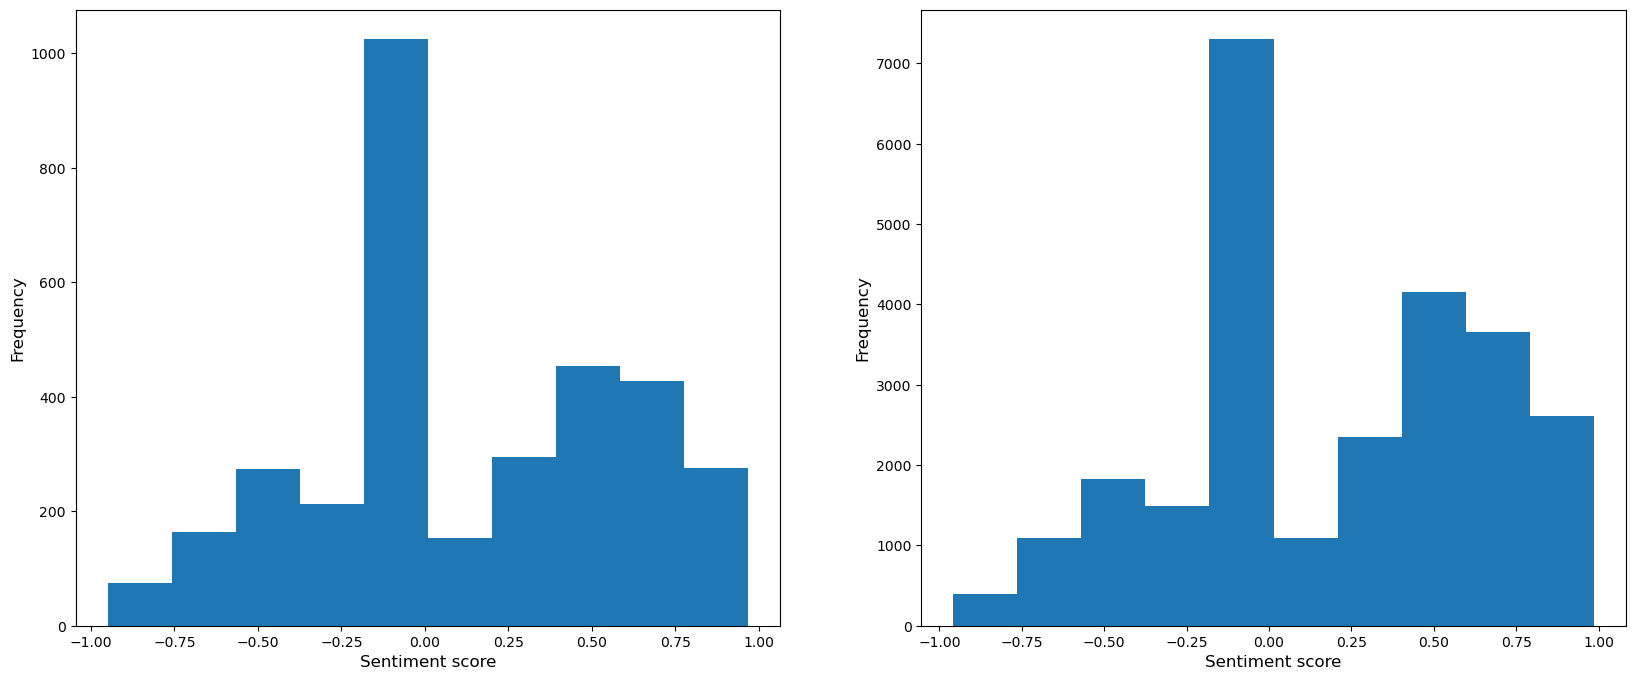

In [26]:
fig, axs = plt.subplots(1, 2, figsize=(20, 8), sharey = False)

axs[0].hist(one_day)

axs[1].hist(another_day)

for ax in axs.flat:
    ax.set_ylabel('Frequency', fontsize = 12) 
    ax.set_xlabel('Sentiment score', fontsize = 12) 

plt.show

## Examining the Time-series

In [27]:
#Mode
#tweets_byday = tweets.groupby(["Date"], as_index=False)["vader_score"].agg(pd.Series.mode)

In [28]:
tweets_byday = tweets.groupby(["Date"], as_index=False)["vader_score"].median()

In [29]:
tweets_byday.head()

,Date,vader_score
0,2009-04-06,0.0000
1,2009-04-07,0.0000
2,2009-04-17,0.1280
3,2009-04-18,0.0258
4,2009-04-19,0.0276


<function matplotlib.pyplot.show(close=None, block=None)>

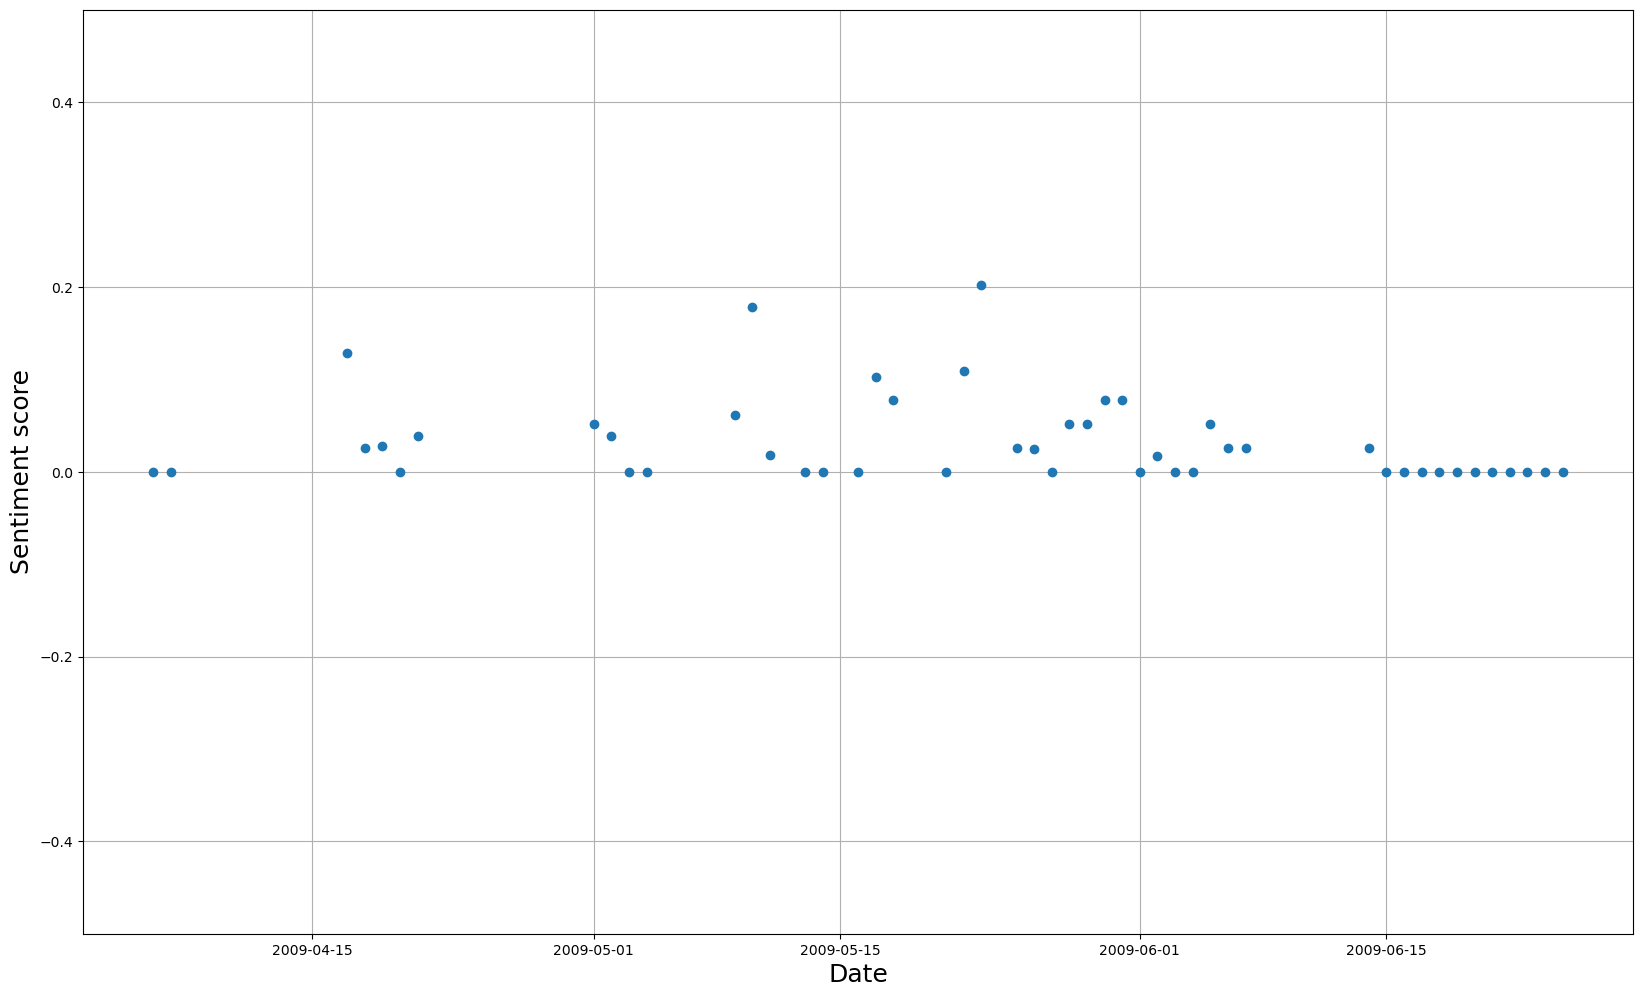

In [30]:
fig, ax=plt.subplots(figsize=(20, 12))

ax.plot(tweets_byday.Date, tweets_byday["vader_score"], linestyle="",marker="o")

plt.ylim([-.5,.5])
plt.grid()

plt.xlabel("Date", fontsize = 18)
plt.ylabel("Sentiment score", fontsize = 18)

plt.show
#data_test['y'].plot(ax=ax, label='test')
#ax.legend();

In [31]:
### Check for stationarity

In [32]:
#Below results show that the data is stationary

# ADF Test
result = adfuller(tweets_byday.vader_score, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

# KPSS Test
result = kpss(tweets_byday.vader_score, regression='c')
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[3].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -5.264716128112944
p-value: 6.47648761557746e-06
Critial Values:
   1%, -3.5778480370438146
Critial Values:
   5%, -2.925338105429433
Critial Values:
   10%, -2.6007735310095064

KPSS Statistic: 0.548855
p-value: 0.030663
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


In [33]:
#Can't decompose due to the missing values
#Error returned:
    #ValueError: You must specify a period or x must be a pandas object with a PeriodIndex or a
    #DatetimeIndex with a freq not set to None

# Multiplicative Decomposition 
#result_mul = seasonal_decompose(tweets_byday['vader_score'], model='multiplicative', extrapolate_trend='freq')

# Additive Decomposition
#result_add = seasonal_decompose(tweets_byday['vader_score'], model='additive', extrapolate_trend='freq')

# Plot
#plt.rcParams.update({'figure.figsize': (10,10)})
#result_mul.plot().suptitle('Multiplicative Decompose', fontsize=22)
#result_add.plot().suptitle('Additive Decompose', fontsize=22)
#plt.show()

## Generating missing dates

In [34]:
start = tweets_byday.Date[0]
end = tweets_byday.Date[len(tweets_byday)-1]

all_dates = pd.date_range(start=start,end=end,freq='D')
len(all_dates)

81

In [35]:
score_imputed = tweets_byday.copy()

In [36]:
score_imputed.set_index('Date', inplace= True)
score_imputed = score_imputed.reindex(all_dates)

#score_imputed = score_imputed.rename_axis('Date')
Dates = score_imputed.index

score_imputed.head(15)

,vader_score
2009-04-06,0.0000
2009-04-07,0.0000
2009-04-08,NaN
2009-04-09,NaN
2009-04-10,NaN
2009-04-11,NaN
2009-04-12,NaN
2009-04-13,NaN
2009-04-14,NaN
2009-04-15,NaN


In [37]:
# Format the data for KNN processing
score_imputed["month"] = score_imputed.index.month
score_imputed["day"] = score_imputed.index.day
score_imputed.reset_index(drop=True, inplace = True)

In [38]:
score_imputed.head(20)

,vader_score,month,day
0,0.0000,4,6
1,0.0000,4,7
2,NaN,4,8
3,NaN,4,9
4,NaN,4,10
5,NaN,4,11
6,NaN,4,12
7,NaN,4,13
8,NaN,4,14
9,NaN,4,15


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


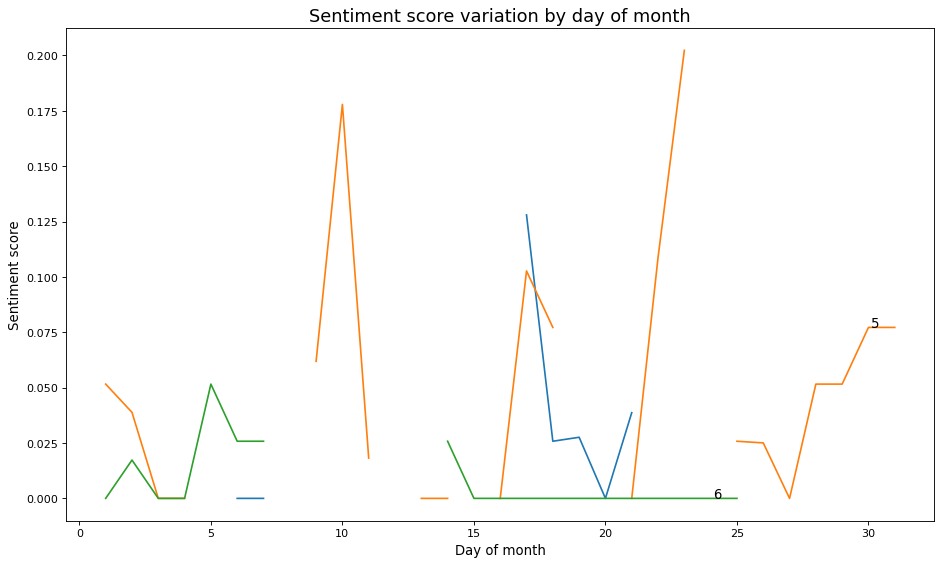

In [39]:
months = score_imputed['month'].unique()

plt.figure(figsize=(14,8), dpi= 80)
for i, y in enumerate(months):
    if i >= 0:        
        plt.plot('day', 'vader_score', data=score_imputed.loc[score_imputed.month==y, :], label=y)#, linestyle = "", marker = ".")
        plt.text(score_imputed.loc[score_imputed.month==y, :].shape[0]-.9, score_imputed.loc[score_imputed.month==y, 'vader_score'][-1:].values[0], y, fontsize=12)
        plt.xlabel("Day of month", fontsize = 12)
        plt.ylabel("Sentiment score", fontsize = 12)
        plt.title("Sentiment score variation by day of month", fontsize = 16)

## Imputing missing values

In [40]:
len(tweets_byday)

48

In [41]:
#There are 33 missing values, 69% of the original dataset - too high a percentage to impute
len(score_imputed) - len(tweets_byday), (len(score_imputed) - len(tweets_byday)) / len(tweets_byday), (len(score_imputed) - len(tweets_byday)) / len(score_imputed)

(33, 0.6875, 0.4074074074074074)

In [42]:
#Score is non-parametric, so non-parametric imputation is most appropriate.
print(shapiro(tweets_byday['vader_score']))

ShapiroResult(statistic=0.7153931856155396, pvalue=2.5081224208634012e-08)


Text(0.5, 0, 'Sentiment score')

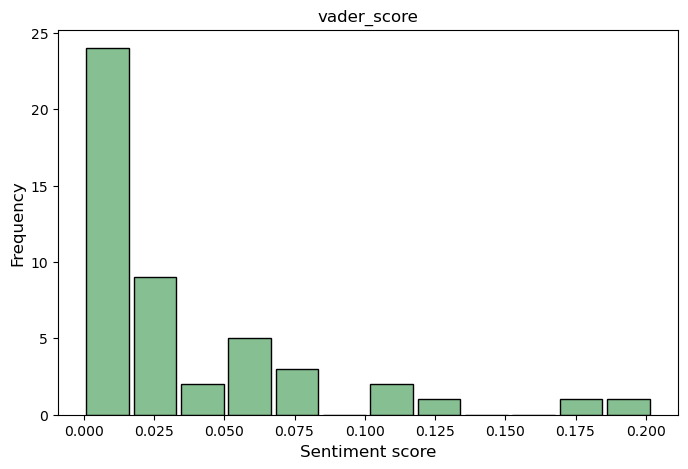

In [43]:
ax = tweets_byday.hist(column='vader_score', edgecolor='black', figsize=(8,5), color = '#86bf91', bins= 12, grid=False, sharex=False, rwidth=0.9)
plt.ylabel('Frequency', fontsize = 12) 
plt.xlabel('Sentiment score', fontsize = 12)

#color='#86bf91'

In [44]:
tweets_byday.set_index('Date', inplace= True)
tweets_byday.to_csv('before_imputing.csv', index=True)

In [45]:
orig_data = score_imputed.copy()
test_KNN = score_imputed.copy()

In [46]:
for i in range(2,6):
    knn_imputer = KNNImputer(n_neighbors=i)
    col_name = 'KNN_neighbours' + str(i)
    test_KNN.loc[:, col_name] = np.nan
    test_KNN[col_name] = knn_imputer.fit_transform(orig_data)

In [47]:
test_KNN

,vader_score,month,day,KNN_neighbours2,KNN_neighbours3,KNN_neighbours4,KNN_neighbours5
0,0.0,4,6,0.00000,0.000000,0.000000,0.00000
1,0.0,4,7,0.00000,0.000000,0.000000,0.00000
2,NaN,4,8,0.03095,0.020633,0.021925,0.05312
3,NaN,4,9,0.11990,0.079933,0.064500,0.05676
4,NaN,4,10,0.11990,0.086000,0.064500,0.05160
...,...,...,...,...,...,...,...
76,0.0,6,21,0.00000,0.000000,0.000000,0.00000
77,0.0,6,22,0.00000,0.000000,0.000000,0.00000
78,0.0,6,23,0.00000,0.000000,0.000000,0.00000
79,0.0,6,24,0.00000,0.000000,0.000000,0.00000


In [48]:
test_KNN["Date"] = Dates

In [49]:
test_KNN.head(20)

,vader_score,month,day,KNN_neighbours2,KNN_neighbours3,KNN_neighbours4,KNN_neighbours5,Date
0,0.0000,4,6,0.000000,0.000000,0.000000,0.00000,2009-04-06
1,0.0000,4,7,0.000000,0.000000,0.000000,0.00000,2009-04-07
2,NaN,4,8,0.030950,0.020633,0.021925,0.05312,2009-04-08
3,NaN,4,9,0.119900,0.079933,0.064500,0.05676,2009-04-09
4,NaN,4,10,0.119900,0.086000,0.064500,0.05160,2009-04-10
5,NaN,4,11,0.098050,0.086000,0.064500,0.05160,2009-04-11
6,NaN,4,12,0.009100,0.006067,0.049025,0.04438,2009-04-12
7,NaN,4,13,0.000000,0.008600,0.011000,0.00880,2009-04-13
8,NaN,4,14,0.000000,0.008600,0.006450,0.00516,2009-04-14
9,NaN,4,15,0.000000,0.000000,0.032000,0.04614,2009-04-15


In [50]:
test_KNN.set_index('Date', inplace= True)

In [51]:
test_KNN.drop(columns=['month', 'day'], inplace=True)

In [52]:
#save to file for Dashboard
test_KNN.to_csv('KNN_neighbours_select.csv', index=True)

### See Dashboard to examine KNN values

2 nearest neighbours chosen as best model to fit imputedvalues

## Carry out the imputation

In [53]:
knn_imputer = KNNImputer(n_neighbors=3)
score_imputed['vader_score'] = knn_imputer.fit_transform(orig_data)

In [54]:
score_imputed

,vader_score,month,day
0,0.000000,4,6
1,0.000000,4,7
2,0.020633,4,8
3,0.079933,4,9
4,0.086000,4,10
...,...,...,...
76,0.000000,6,21
77,0.000000,6,22
78,0.000000,6,23
79,0.000000,6,24


In [55]:
score_imputed["Date"] = Dates
score_imputed.set_index('Date', inplace= True)

<function matplotlib.pyplot.show(close=None, block=None)>

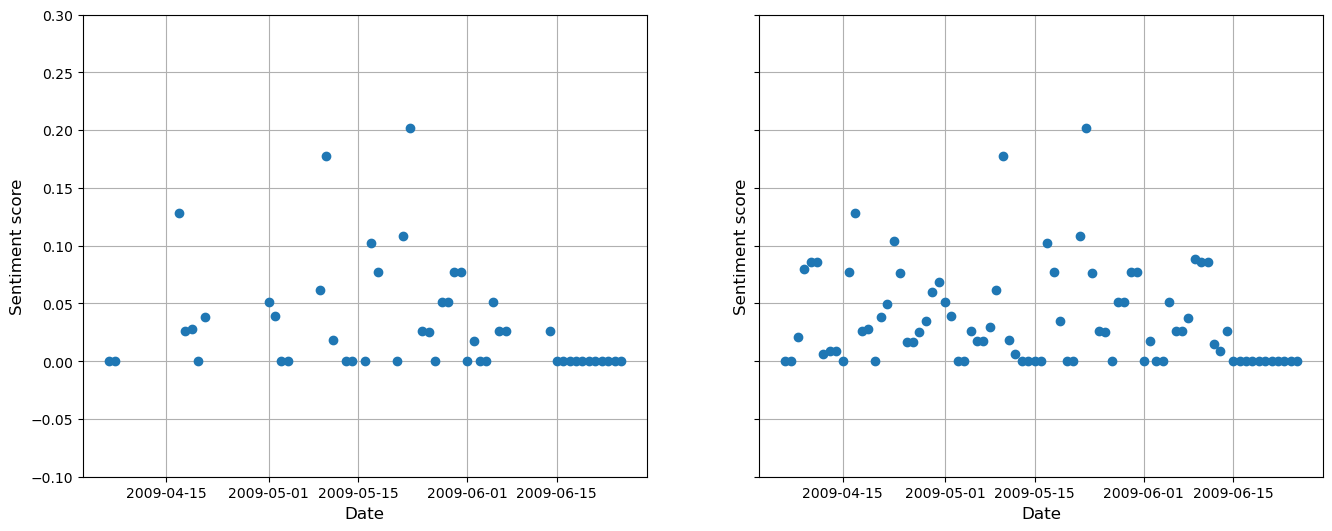

In [56]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6), sharey = True)
plt.ylim([-.1,.3])

axs[0].plot(tweets_byday.index, tweets_byday['vader_score'], linestyle="",marker="o")
axs[0].grid()

axs[1].plot(score_imputed.index, score_imputed['vader_score'], linestyle="",marker="o")
axs[1].grid()

for ax in axs.flat:
    ax.set_xlabel('Date', fontsize = 12) 
    ax.set_ylabel('Sentiment score', fontsize = 12) 

plt.show

In [57]:
#Previous p-values were 6.48 x 10^-6 and 0.03

# ADF Test
result = adfuller(score_imputed.vader_score, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

# KPSS Test
result = kpss(score_imputed.vader_score, regression='c')
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[3].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -6.348559919547954
p-value: 2.6455096688414965e-08
Critial Values:
   1%, -3.5159766913976376
Critial Values:
   5%, -2.898885703483903
Critial Values:
   10%, -2.5866935058484217

KPSS Statistic: 0.221966
p-value: 0.100000
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


/tmp/ipykernel_5019/2273384205.py:12: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(score_imputed.vader_score, regression='c')


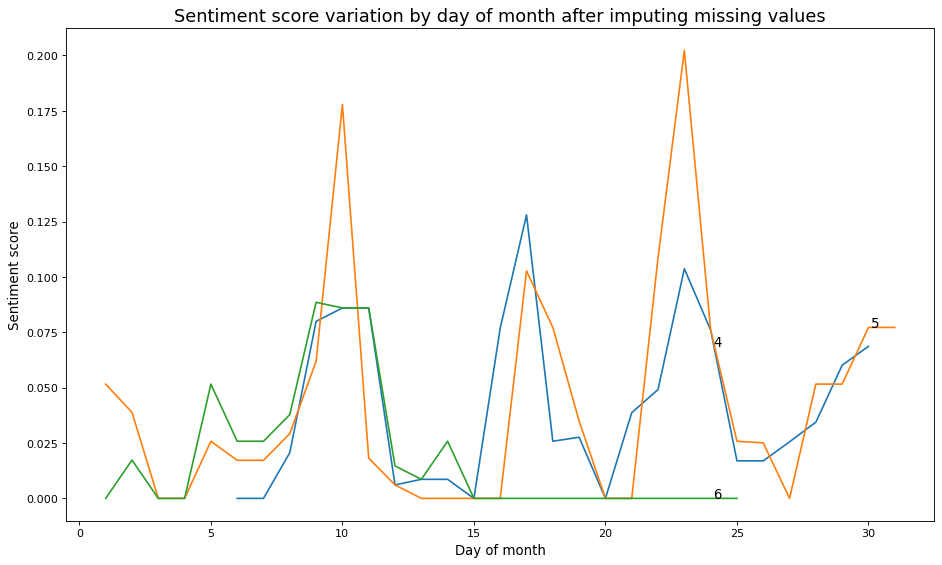

In [58]:
months = score_imputed['month'].unique()

plt.figure(figsize=(14,8), dpi= 80)
for i, y in enumerate(months):
    if i >= 0:        
        plt.plot('day', 'vader_score', data=score_imputed.loc[score_imputed.month==y, :], label=y)
        plt.text(score_imputed.loc[score_imputed.month==y, :].shape[0]-.9, score_imputed.loc[score_imputed.month==y, 'vader_score'][-1:].values[0], y, fontsize=12)
        plt.xlabel("Day of month", fontsize = 12)
        plt.ylabel("Sentiment score", fontsize = 12)
        plt.title("Sentiment score variation by day of month after imputing missing values", fontsize = 16)

In [59]:
score_imputed.drop(["month", "day"], axis = 1, inplace = True)

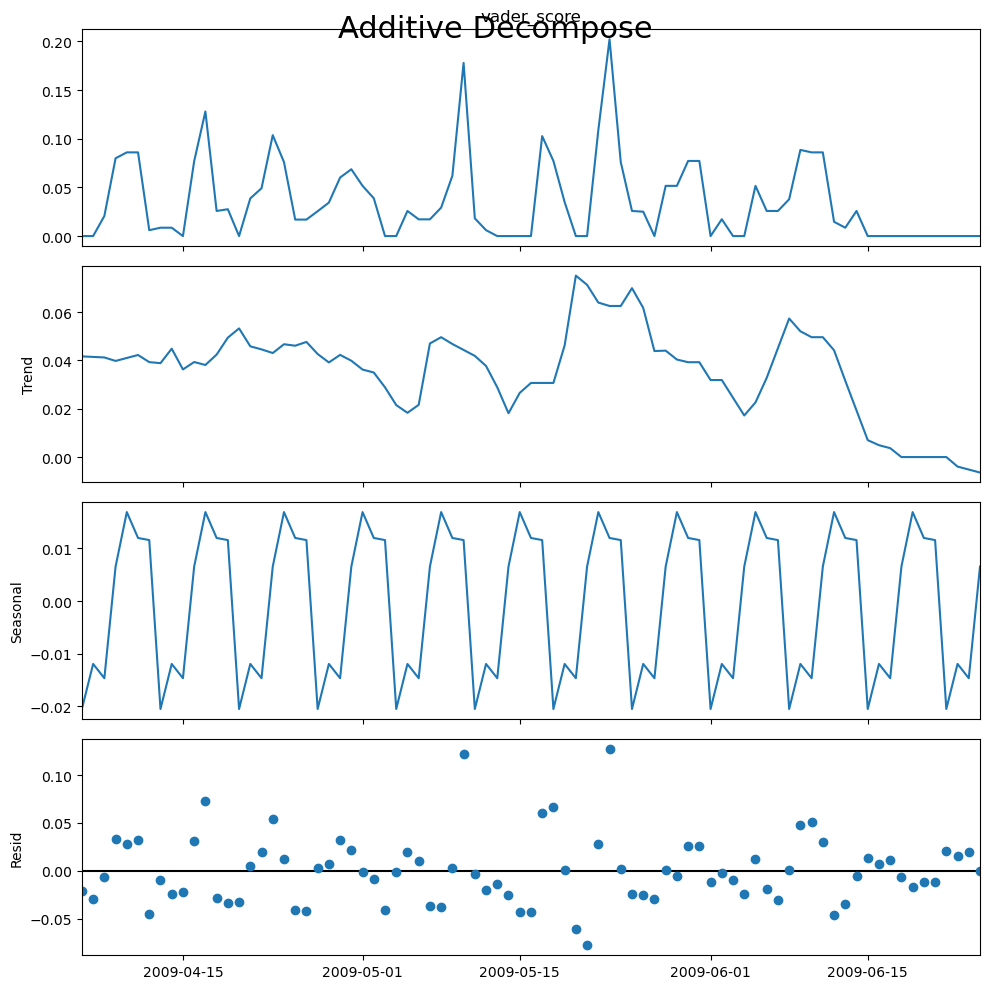

In [60]:
# Additive Decomposition
result_add = seasonal_decompose(score_imputed['vader_score'], model='additive', extrapolate_trend='freq')

#Plot
plt.rcParams.update({'figure.figsize': (10,10)})
result_add.plot().suptitle('Additive Decompose', fontsize=22)
plt.show()

In [61]:
#save to file
score_imputed.to_csv('score_imputed.csv', index=True) 

## Forecasting

#### Autocorrelation and differencing

As a result of the differencing below d will be set to 0 (as there is no trend), p to 3, and q to 3 in ARIMA and SARIMA Models

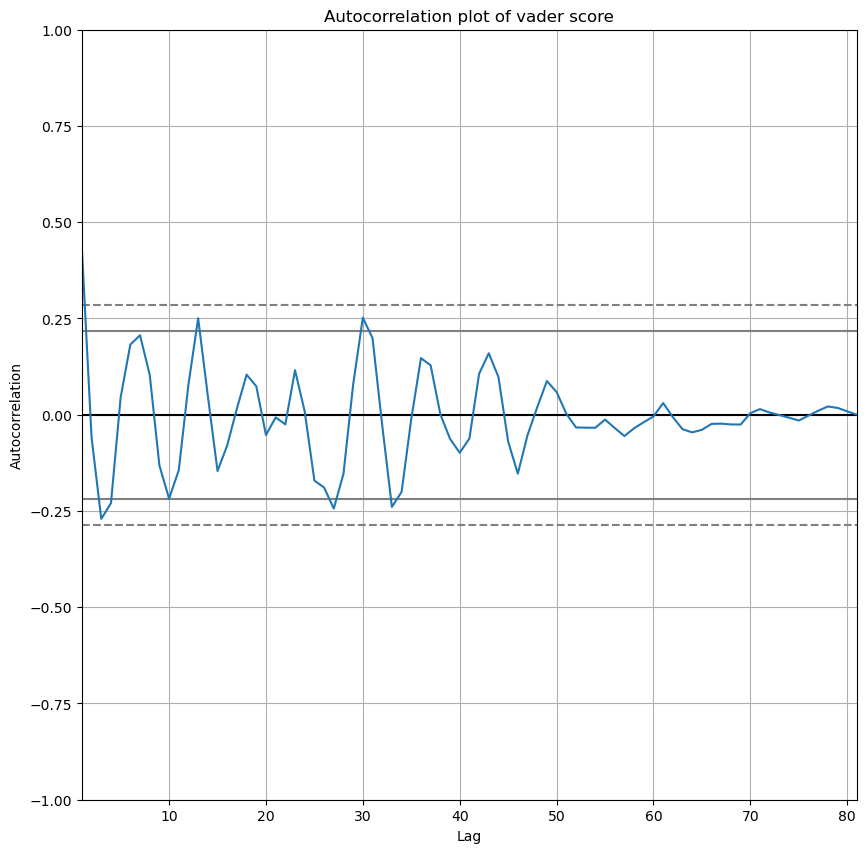

In [62]:
autocorrelation_plot(score_imputed["vader_score"])
plt.title("Autocorrelation plot of vader score")
plt.show()

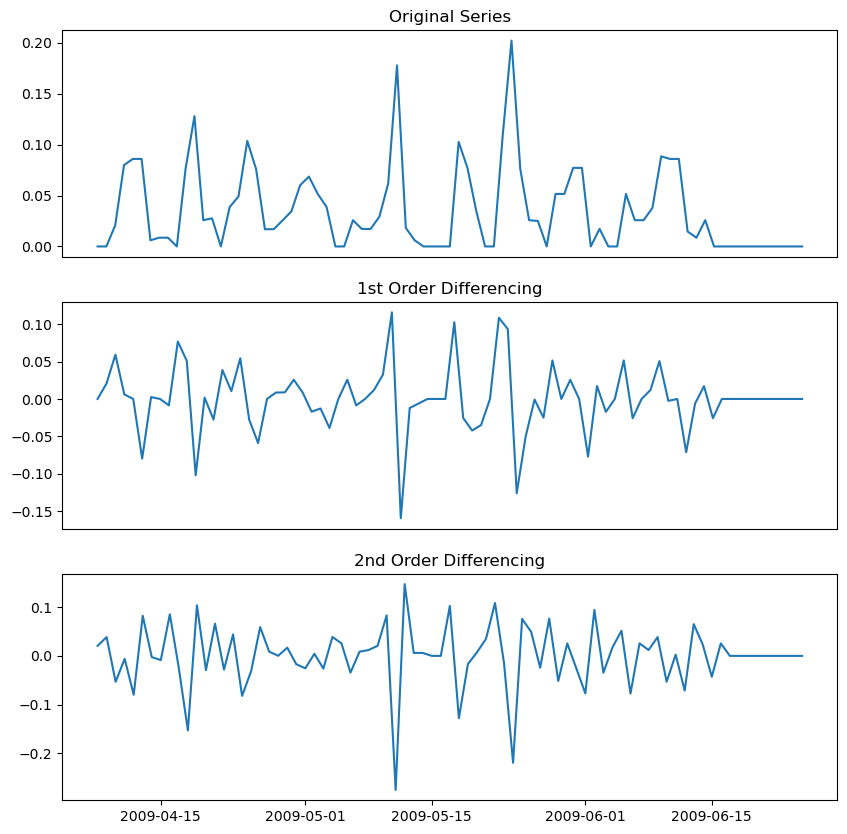

In [63]:
fig, (ax1, ax2, ax3) = plt.subplots(3)
ax1.plot(score_imputed['vader_score']); ax1.set_title('Original Series'); ax1.axes.xaxis.set_visible(False)
# 1st Differencing
ax2.plot(score_imputed['vader_score'].diff()); ax2.set_title('1st Order Differencing'); ax2.axes.xaxis.set_visible(False)
# 2nd Differencing
ax3.plot(score_imputed['vader_score'].diff().diff()); ax3.set_title('2nd Order Differencing')
plt.show()

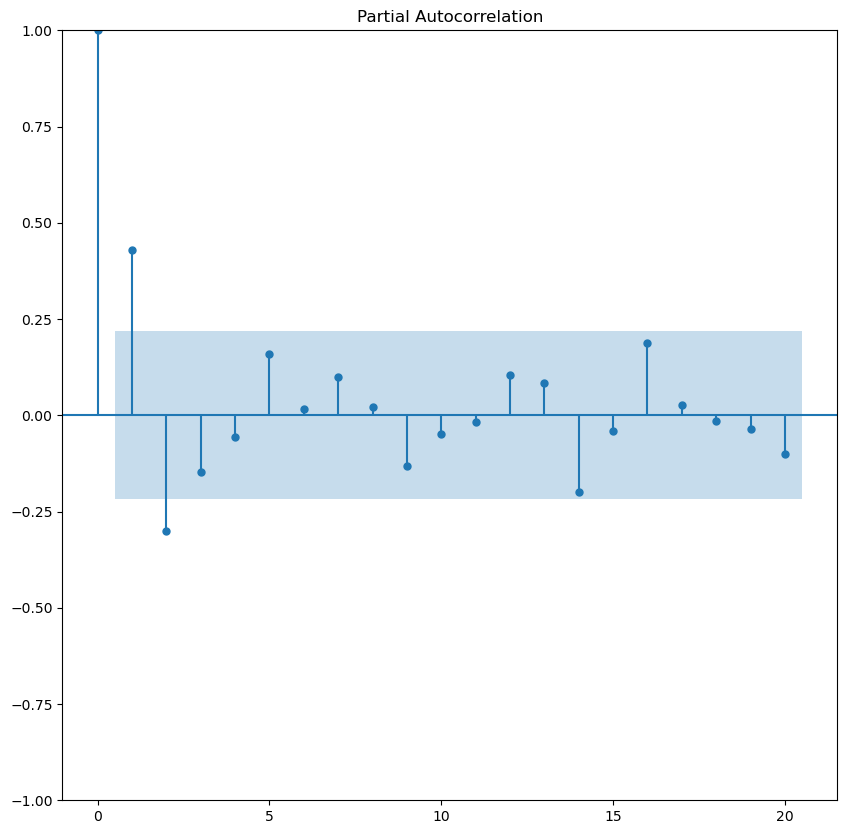

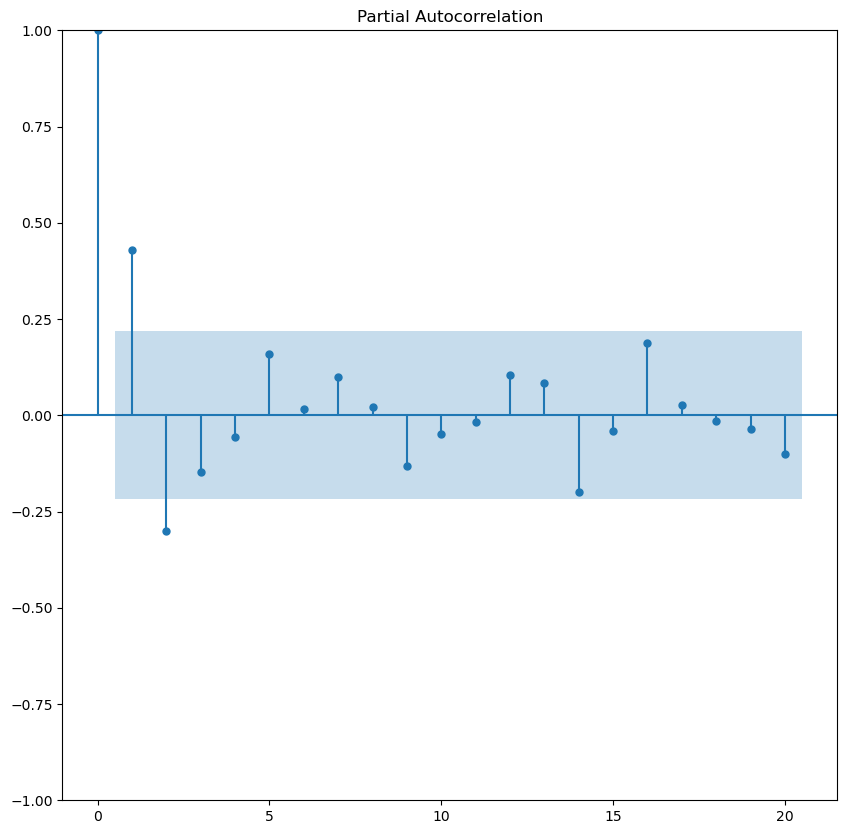

In [64]:
plot_pacf(score_imputed['vader_score'])

#### ARIMA

Used as the data is not stationary, but has a trend.

In [65]:
# 1 week, 1 month, and 3 months
pred_periods = [7, 31, 93]

In [66]:
#https://people.duke.edu/~rnau/411arim.htm

ARIMAmodel = SARIMAX(score_imputed, order = (3, 0, 3))
ARIMAmodel = ARIMAmodel.fit()

for x in range(len(pred_periods)):
    y_pred = ARIMAmodel.get_forecast(pred_periods[x])
    y_pred_df = y_pred.conf_int(alpha = 0.05) 
    y_pred_df["Predictions"] = ARIMAmodel.predict(start = y_pred_df.index[0],
                                              end = y_pred_df.index[-1])
    y_pred_df.index.name='Date'
    if x == 0:
        y_pred_out_week_ARIMA = y_pred_df["Predictions"]
    if x == 1:
        y_pred_out_month_ARIMA = y_pred_df["Predictions"]
    if x == 2:
        y_pred_out_3month_ARIMA = y_pred_df["Predictions"]

/home/jacksbed/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/jacksbed/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/jacksbed/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/jacksbed/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.
/home/jacksbed/anaconda3/lib/

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.30496D+00    |proj g|=  2.93125D+01

At iterate    5    f= -1.55171D+00    |proj g|=  2.29149D+00

At iterate   10    f= -1.78665D+00    |proj g|=  4.44613D-01

At iterate   15    f= -1.79051D+00    |proj g|=  7.55835D-02

At iterate   20    f= -1.79099D+00    |proj g|=  1.17509D-01

At iterate   25    f= -1.79104D+00    |proj g|=  8.03976D-02

At iterate   30    f= -1.79166D+00    |proj g|=  9.93105D-02

At iterate   35    f= -1.79203D+00    |proj g|=  3.54519D-02

At iterate   40    f= -1.84454D+00    |proj g|=  1.54641D+00

At iterate   45    f= -1.86445D+00    |proj g|=  5.86273D-02

At iterate   50    f= -1.86515D+00    |proj g|=  1.85670D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

Text(0.5, 0.98, 'Sentiment score prediction ARIMA')

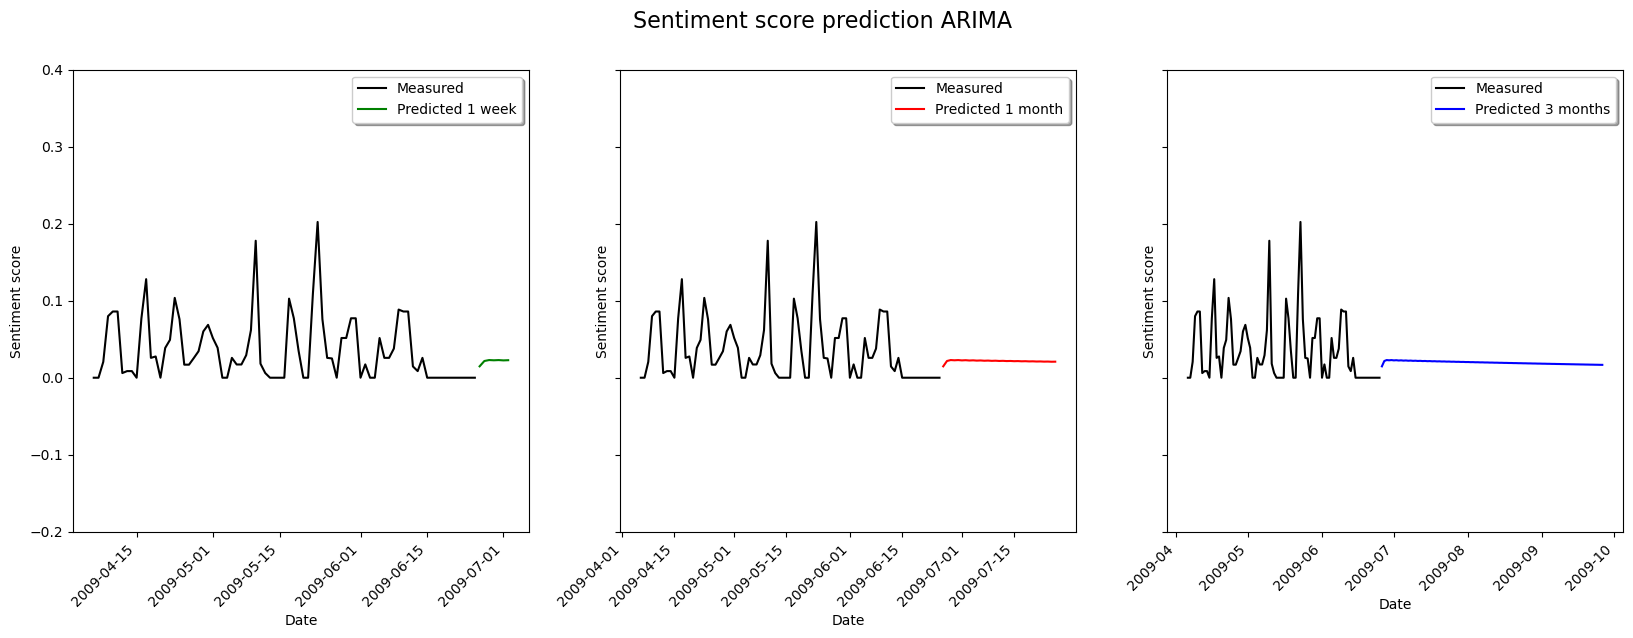

In [67]:
fig, axs = plt.subplots(1, 3, figsize=(20, 6), sharey = True)
plt.ylim([-.2,.4])

axs[0].plot(score_imputed, color = "black", label = 'Data')
axs[0].set_ylabel('Sentiment score')
axs[0].set_xlabel('Date')
axs[0].plot(y_pred_out_week_ARIMA, color='Green', label = '1 week')
axs[0].set_xticks(axs[0].get_xticks(), axs[0].get_xticklabels(), rotation=45, ha='right')
axs[0].legend(('Measured', 'Predicted 1 week'), loc='upper right', shadow=True)

axs[1].plot(score_imputed, color = "black", label = 'Data')
axs[1].set_ylabel('Sentiment score')
axs[1].set_xlabel('Date')
axs[1].plot(y_pred_out_month_ARIMA, color='Red', label = '1 month')
axs[1].set_xticks(axs[1].get_xticks(), axs[1].get_xticklabels(), rotation=45, ha='right')
axs[1].legend(('Measured', 'Predicted 1 month'), loc='upper right', shadow=True)

axs[2].plot(score_imputed, color = "black", label = 'Data')
axs[2].set_ylabel('Sentiment score')
axs[2].set_xlabel('Date')
axs[2].plot(y_pred_out_3month_ARIMA, color='Blue', label = '3 month')
axs[2].set_xticks(axs[2].get_xticks(), axs[2].get_xticklabels(), rotation=45, ha='right')
axs[2].legend(('Measured', 'Predicted 3 months'), loc='upper right', shadow=True)

fig.suptitle('Sentiment score prediction ARIMA', fontsize=16)

#### SARIMA

Used to account for both trend and seasonality

This is more appropriate here as the data has seasonality, but no trend.

In [68]:
SARIMAmodel = SARIMAX(score_imputed, order = (3, 0, 3), seasonal_order=(3, 0, 3, 7))
SARIMAmodel = SARIMAmodel.fit()

for x in range(len(pred_periods)):
    y_pred = SARIMAmodel.get_forecast(pred_periods[x])
    y_pred_df = y_pred.conf_int(alpha = 0.05) 
    y_pred_df["Predictions"] = SARIMAmodel.predict(start = y_pred_df.index[0],
                                                end = y_pred_df.index[-1])
    y_pred_df.index.name='Date'
    if x == 0:
        y_pred_out_week_SARIMA = y_pred_df["Predictions"]
    if x == 1:
        y_pred_out_month_SARIMA = y_pred_df["Predictions"]
    if x == 2:
        y_pred_out_3month_SARIMA = y_pred_df["Predictions"]

/home/jacksbed/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/jacksbed/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/jacksbed/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/jacksbed/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/jacksbed/anaconda3/lib/python3.11/site-packages/statsmo

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.11150D+00    |proj g|=  3.92089D+01

At iterate    5    f= -1.54307D+00    |proj g|=  2.69211D+00

At iterate   10    f= -1.79430D+00    |proj g|=  1.96198D+00

At iterate   15    f= -1.84050D+00    |proj g|=  7.92134D-02

At iterate   20    f= -1.84165D+00    |proj g|=  2.82180D-02

At iterate   25    f= -1.84227D+00    |proj g|=  8.08278D-01

At iterate   30    f= -1.84400D+00    |proj g|=  1.54132D-01

At iterate   35    f= -1.84430D+00    |proj g|=  4.74461D-02

At iterate   40    f= -1.84527D+00    |proj g|=  3.02554D-01

At iterate   45    f= -1.84775D+00    |proj g|=  4.04031D-01

At iterate   50    f= -1.85156D+00    |proj g|=  2.00653D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/home/jacksbed/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Text(0.5, 0.98, 'Sentiment score prediction SARIMA')

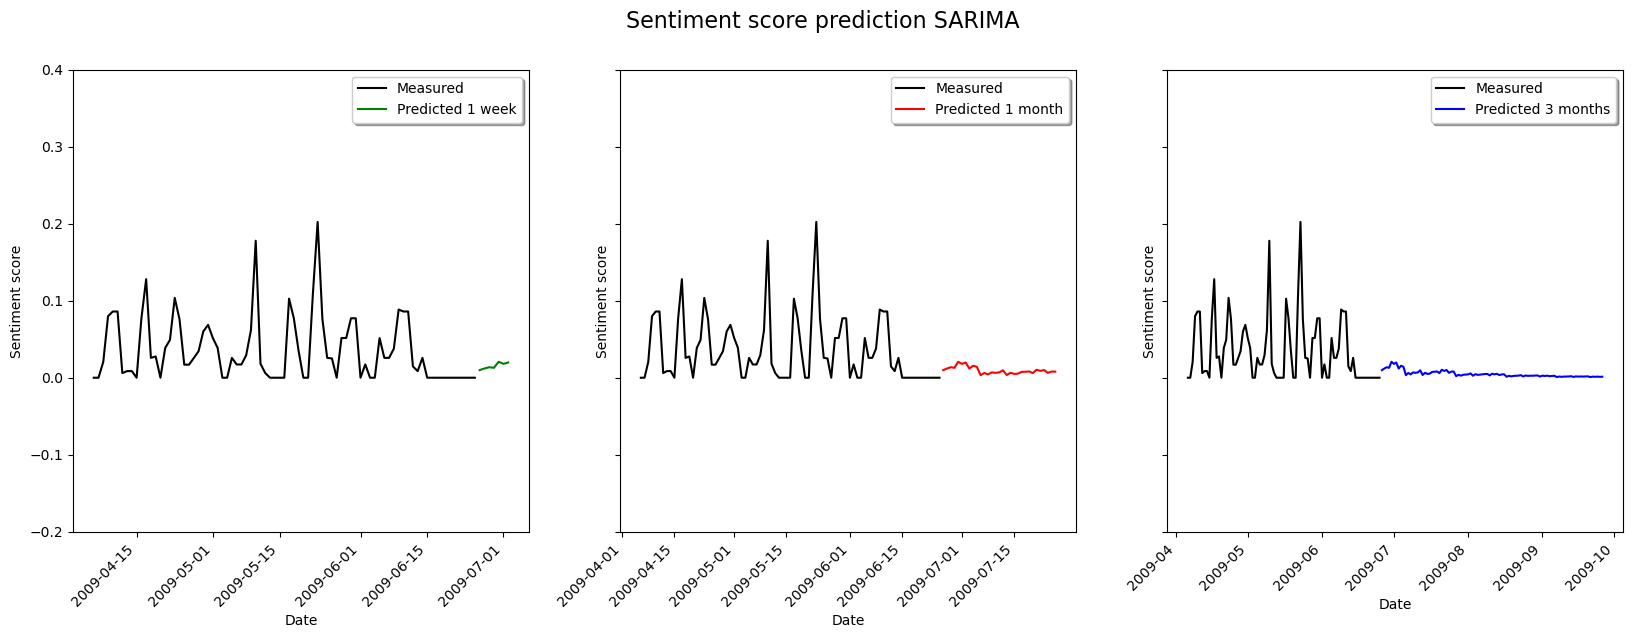

In [69]:
fig, axs = plt.subplots(1, 3, figsize=(20, 6), sharey = True)
plt.ylim([-.2,.4])

axs[0].plot(score_imputed, color = "black", label = 'Data')
axs[0].set_ylabel('Sentiment score')
axs[0].set_xlabel('Date')
axs[0].plot(y_pred_out_week_SARIMA, color='Green', label = '1 week')
axs[0].set_xticks(axs[0].get_xticks(), axs[0].get_xticklabels(), rotation=45, ha='right')
axs[0].legend(('Measured', 'Predicted 1 week'), loc='upper right', shadow=True)

axs[1].plot(score_imputed, color = "black", label = 'Data')
axs[1].set_ylabel('Sentiment score')
axs[1].set_xlabel('Date')
axs[1].plot(y_pred_out_month_SARIMA, color='Red', label = '1 month')
axs[1].set_xticks(axs[1].get_xticks(), axs[1].get_xticklabels(), rotation=45, ha='right')
axs[1].legend(('Measured', 'Predicted 1 month'), loc='upper right', shadow=True)

axs[2].plot(score_imputed, color = "black", label = 'Data')
axs[2].set_ylabel('Sentiment score')
axs[2].set_xlabel('Date')
axs[2].plot(y_pred_out_3month_SARIMA, color='Blue', label = '3 month')
axs[2].set_xticks(axs[2].get_xticks(), axs[2].get_xticklabels(), rotation=45, ha='right')
axs[2].legend(('Measured', 'Predicted 3 months'), loc='upper right', shadow=True)

fig.suptitle('Sentiment score prediction SARIMA', fontsize=16)

### Split dataset into test and train to check validity of forecast data

#### Check validity of nearly 1 month forecast (26 days) given nearly 2 months data (54 days) - data split into 2/3rds 1/3rd

In [95]:
len(score_imputed)*2/3

54.0

In [92]:
# Split into training and testing
train = score_imputed.loc[:'2009-05-30']
test = score_imputed.loc['2009-05-31':]

In [93]:
train, test

(            vader_score
 Date                   
 2009-04-06     0.000000
 2009-04-07     0.000000
 2009-04-08     0.020633
 2009-04-09     0.079933
 2009-04-10     0.086000
 2009-04-11     0.086000
 2009-04-12     0.006067
 2009-04-13     0.008600
 2009-04-14     0.008600
 2009-04-15     0.000000
 2009-04-16     0.076900
 2009-04-17     0.128000
 2009-04-18     0.025800
 2009-04-19     0.027600
 2009-04-20     0.000000
 2009-04-21     0.038700
 2009-04-22     0.049150
 2009-04-23     0.103683
 2009-04-24     0.076033
 2009-04-25     0.016950
 2009-04-26     0.016950
 2009-04-27     0.025550
 2009-04-28     0.034400
 2009-04-29     0.060133
 2009-04-30     0.068667
 2009-05-01     0.051600
 2009-05-02     0.038850
 2009-05-03     0.000000
 2009-05-04     0.000000
 2009-05-05     0.025800
 2009-05-06     0.017200
 2009-05-07     0.017200
 2009-05-08     0.029233
 2009-05-09     0.061900
 2009-05-10     0.177900
 2009-05-11     0.018200
 2009-05-12     0.006067
 2009-05-13     0.000000


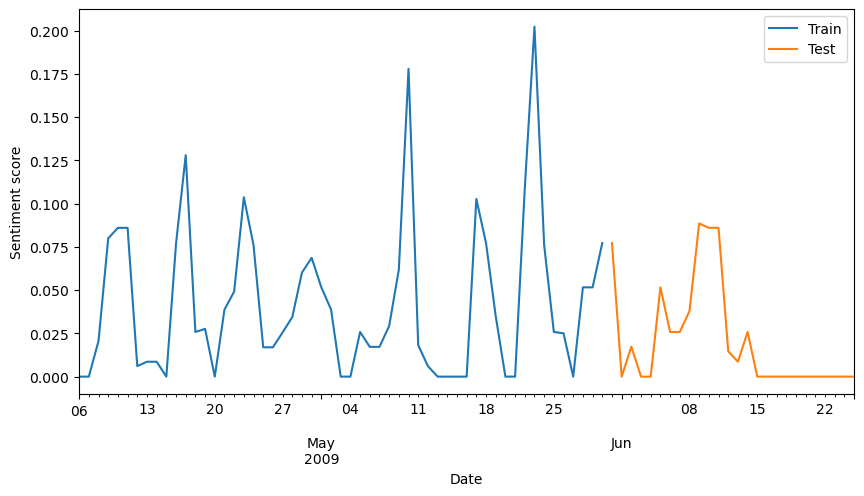

In [94]:
# Plot the last 10 years of training data and the 2 of testing
ax = train.plot(figsize=(10, 5))
test.plot(ax=ax)
plt.legend(['Train', 'Test'])
plt.xlabel('Date')
plt.ylabel('Sentiment score')
plt.show()

In [114]:
SARIMAmodel = SARIMAX(train, order = (3, 0, 3), seasonal_order=(3, 0, 3, 6))
SARIMAmodel = SARIMAmodel.fit()

y_pred = SARIMAmodel.get_forecast(26)
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = SARIMAmodel.predict(start = y_pred_df.index[0],
                                                end = y_pred_df.index[-1])
y_pred_df.index.name='Date'
y_pred_out_SARIMA = y_pred_df["Predictions"]

/home/jacksbed/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/jacksbed/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/jacksbed/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/jacksbed/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/jacksbed/anaconda3/lib/python3.11/site-packages/statsmo

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.18755D+00    |proj g|=  2.63845D+01

At iterate    5    f= -1.42145D+00    |proj g|=  1.22179D+00

At iterate   10    f= -1.66688D+00    |proj g|=  1.92423D-01

At iterate   15    f= -1.69602D+00    |proj g|=  3.86657D-01

At iterate   20    f= -1.69677D+00    |proj g|=  9.22072D-01

At iterate   25    f= -1.70299D+00    |proj g|=  1.38553D+00

At iterate   30    f= -1.70895D+00    |proj g|=  1.65517D+00

At iterate   35    f= -1.72293D+00    |proj g|=  4.11167D-01

At iterate   40    f= -1.73868D+00    |proj g|=  7.69272D-02

At iterate   45    f= -1.75115D+00    |proj g|=  9.73411D-01

At iterate   50    f= -1.76851D+00    |proj g|=  3.81617D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/home/jacksbed/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


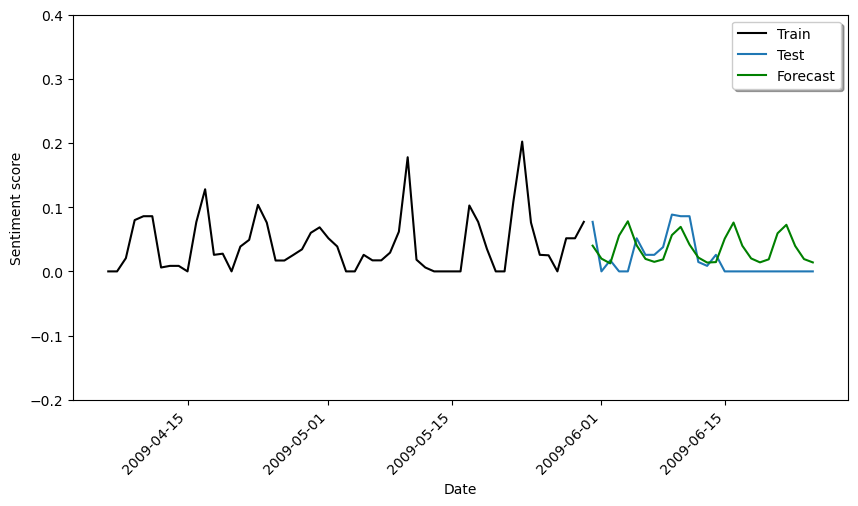

In [115]:
fig, axs = plt.subplots(1, 1, figsize=(10, 5))
plt.ylim([-.2,.4])

axs.plot(train, color = "black", label = 'Train')
axs.set_ylabel('Sentiment score')
axs.set_xlabel('Date')
axs.plot(test, label = 'Test')
axs.plot(y_pred_out_SARIMA, color='Green', label = 'Predictions')
axs.set_xticks(axs.get_xticks(), axs.get_xticklabels(), rotation=45, ha='right')
axs.legend(('Train', 'Test', 'Forecast'), loc='upper right', shadow=True)

In [70]:
y_pred_out_week_SARIMA.to_csv('week_prediction.csv', index=True)
y_pred_out_month_SARIMA.to_csv('month_prediction.csv', index=True)
y_pred_out_3month_SARIMA.to_csv('3month_prediction.csv', index=True)